-----------




In a [previous post](./psychology-today-intro.html), I introduced some data I scraped from Psychology Today's [Find A Therapist](https://therapists.psychologytoday.com/rms/?utm_source=PT_Psych_Today&utm_medium=House_Link&utm_campaign=PT_TopNavF_Therapist) directory. The data (and code) can be found in my [github repository](https://github.com/stevenfelix/PsychologyToday).

The first thing I'd like to do with this data is learn a bit more about the providers of therapy in private practice today. Who are they? How were they trained? What degrees do they hold? What issues do they treat? And what methods do they use?

Though simple, these questions are hard to address because traditional data sources typically provide only one or two types of information about providers. Insurance reimbursement data are great for learning about services rendered (length of therapy, types of treatment actually provided) and perhaps about the qualifications of the providers (at least their degree). But they do not always include a diagnosis (only certain professionals can diagnose); they fail to capture anything about providers who don't accept insurance; and they don't convey any specifics about the providers. Graduation/licensure data are good for describing the number of people eligible to provide therapy (and their respective degrees and certifications), and perhaps what kind of training they received (but not really, since every school is different). But, not everyone in practice has a professional degree (e.g., [life coaches](https://www.psychologytoday.com/blog/women-who-stray/201402/life-coaches-and-mental-illness)), and these data still provide only the most general information about providers' training.

Of course, professional profiles on Psychology Today also have their own problems and biases, but I'll address these later. For now, let's learn a little about what type of providers you're going to find if you were looking for a therapist today on Psychology Today.

### Sampling
My [previous post](./psychology-today-intro.html) describes my sampling method in more detail. Briefly, I semi-randomly selected 100-200 provider profiles from each of the 50 US states. Less populated states, such as the Dakotas and Alaska, have closer to 100 samples, whereas larger states have at least 200. The final sample is 7657 profiles. The profiles may not be truly representative of all clinicians, but they should be representative of clinicians on Psychology Today.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("white")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
import json
import pandas as pd

data = pd.read_csv('../data/therapist_profiles.csv', index_col='id_num')

with open("../data/profiledict.json", "r") as fd:
    profile_dict = json.load(fd)

with open("../data/profilefeatures_bool_dict.json", "r") as fd:
    features_dict = json.load(fd)

def proportions(series):
    return series.value_counts() / len(data)

## Gender

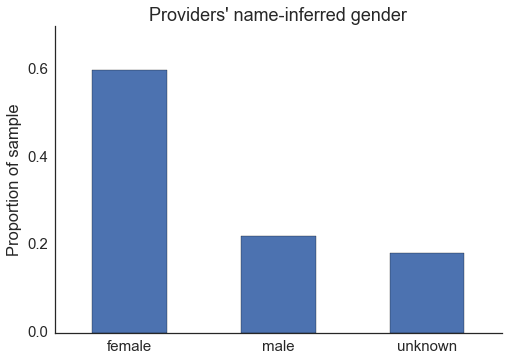

In [2]:
import gender_guesser.detector as gender
d = gender.Detector()
data['gender'] = [d.get_gender(name.split()[0]) for name in data.name]
recodes = {'male': 'male', 'female': 'female', 'mostly_female': 'female', 'mostly_male':'male', 'andy':'unknown','unknown':'unknown'}
gender = proportions(data.gender.map(recodes))

ax = gender.plot(kind = 'bar', yticks = np.arange(0,.75,.2), rot = 0, title = "Providers' name-inferred gender")
ax.set_ylabel("Proportion of sample")
ax.set_ylim(0,.7);
sns.despine()

Interestingly, profiles do not include the gender of the provider (though there is a gender filter for use when searching for male or female therapists), so I used the python package 
`gender_guesser` to infer gender based on providers' first names. 'Unknown' providers either have androgynous names or list the name of their private practice (e.g., Mount Hope Counseling Services). Visiting a few of these profiles suggests a similar gender distribution (i.e., mostly women).

It is not suprising to see this distribution. The gender gap in psychology has been known for a while. In 2013, [women outnumbered men 2 to 1](http://www.apa.org/workforce/publications/13-demographics/index.aspx). The gap is wider in counseling and social work ([73% and 81%, respectively](https://www.bls.gov/cps/cpsaat11.htm)).

## Qualifications

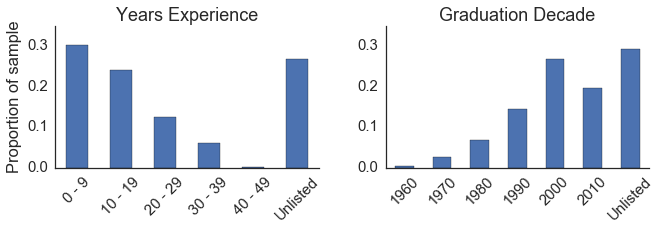

In [3]:
fig,ax = plt.subplots(1,2, figsize = (10,4))

labels = ["{0} - {1}".format(i, i + 9) for i in [0,10,20,30,40]]
labels.append('Unlisted')
data['years_ord'] = pd.cut(data.years.fillna(99), [0,10,20,30, 40,50,100], right=False, labels=labels)
years = proportions(data.years_ord)[labels]
years.plot(kind = 'bar', rot = 45, title = 'Years Experience', ax =ax[0])
ax[0].set_ylim(0,.35)
ax[0].set_yticks(np.arange(0,.38,.1));
ax[0].set_ylabel('Proportion of sample')

import math

graduated = data.graduated.fillna(3000).apply(lambda x: int(math.floor(x / 10.0)) * 10)
graduated = proportions(graduated).sort_index()
labels = graduated.index.tolist()[:-1]
labels.append('Unlisted')
graduated.plot(kind = 'bar', rot = 45, ax = ax[1])
ax[1].set_title('Graduation Decade')
ax[1].set_ylim(0,.35)
ax[1].set_yticks(np.arange(0,.38,.1));
ax[1].set_xticklabels(labels)

sns.despine()
fig.tight_layout(pad = 2)

Overall, the pool of providers is quite young. Greater than 50% of providers have less than 20 years of experience providing services, and greater than 30% have less 10. I say 'greater than' because a huge chunk of providers do not include this information in their profiles, and my hunch is that a preponderance of them are less experienced providers that would prefer not to draw attention to the number of years they've been in practice.

The step-like progression is also interesting. This is likely a natural distribution in any decently paying, stable profession (i.e., one that is not threatened by automation or outsourcing). It probably results from the combination of attrition (burnout, retiring, career change, death) and job growth over time (the BLS projects need for psychologists will [grow 20%](https://www.bls.gov/ooh/life-physical-and-social-science/psychologists.htm) between 2014 and 2024).

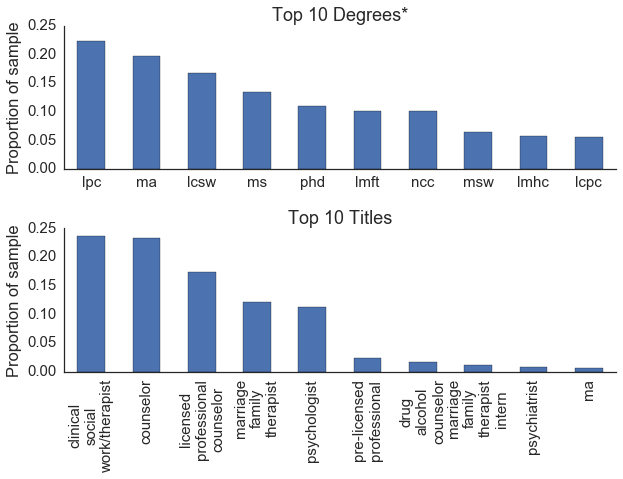

In [4]:
fig,ax = plt.subplots(2,1, figsize=(9,7))

def plot_top10(var, prettytitle, ax, rot = 0):
    top10 = pd.Series(profile_dict[var]['counts']).sort_values(ascending=False).iloc[:10] / len(data)
    top10.plot(kind='bar', ax = ax, rot=rot, title='Top 10 {}'.format(prettytitle))
    labels = ['\n'.join(i.replace('and ','').replace('or ','').split()) for i in top10.index]
    ax.set_xticklabels(labels)
    ax.set_ylabel('Proportion of sample')

plot_top10('degrees','Degrees*', ax[0])

s = proportions(data.title)[:10]
labels = ['\n'.join(i.replace('and ','').replace('or ','').replace('& ','').split()) for i in s.index]
s.plot(kind='bar', rot = 90, ax= ax[1], title = 'Top 10 Titles')
ax[1].set_xticklabels(labels)
ax[1].set_ylabel('Proportion of sample')

sns.despine()
fig.tight_layout();

Psychology Today does not distinguish between academic or professional degrees and licensures or certifications\*\*. Thus, they are lumped together in the top graph. It is important to note, that providers are allowed to list as many degrees/certifications as they want, so a particular degree listed may not be their highest or primary professional degree.

The most commonly held degree/certification is an LPC. This likely goes along with #2, the Master of Arts. In most states, having a master's is the educational prerequisite to getting an LPC, so an LPC should also have an MA. Interestingly, only about 10% of providers have a PhD, which was traditionally the most common degree held by psychotherapists.

The trends are little bit clearer in the bottom graph, which displays the most common titles. Since providers typically only list one title, it is usually their highest attained credential. 
If you combine the licensed and non-licensed categories (which are probably the same), "Counselor" is the most common title held by providers of psychotherapy\*\*\* (>35%), followed by clinical social worker (~25%), and then marriage & family therapist (~15%) and psychologist (~15%). This highlights another well-known trend: mental health provision is increasingly moving from psychologists with PhDs (or PsyDs) to counselors and social workers with master's degrees. (It is worth noting that before psychologists, it was psychiatrists who were the primary providers of psychotherapy).

A somewhat surprising pattern is the relatively few number of drug and alcohol counselors. Considering the prevalence of drug and alcohol problems, one might think there would be many more providers specifically trained to handle addiction. Of course, this is an underestimate of the number of addiction specialists, as the majority of specialists likely operate out of hospitals and other treatment centers, rather than private practice. But still, these data may point to an area of the mental health field that needs much more growth and attention.

In sum, it is comforting to know that greater than around 90% of mental health providers hold some kind of professional degree and licensure/credential.

\*Acronyms: LPC = Licensed professional counselor; LCSW = Licensed clinical social worker; LMFT = Licenced marital and family counselor; NCC = National certififed counselor; LMHC = Licenced mental health counselor. 

\*\*A degree reflects your training and education, whereas a certification/license is granted by some overseeing body and allows the provider to provide treatment under a particular title. 

\*\*\* Some may argue that these providers perform counseling, not psychotherapy, but there is not really a clear distinction between the two, nor an overseeing body that regulates what kind of psychosocial treatments counselors vs. social workers, vs. psychologists can provide.

In [5]:
top10 = data.title.value_counts()[:9].index
data['title10'] = [title if title in top10 else 'other' for title in data.title]
top10 = data.title10.value_counts().index

data['gender2'] = data.gender.map(recodes)

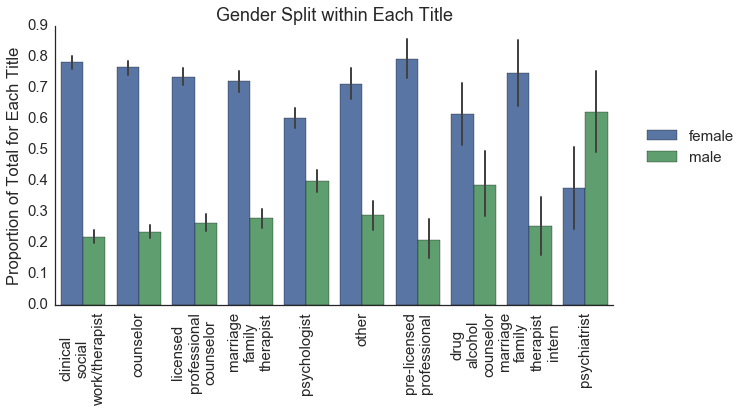

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
d2 = data[data.gender2 != 'unknown']
dummies = pd.get_dummies(d2.gender2).join(d2.title10)
dummies_long = pd.melt(frame = dummies, id_vars = 'title10')
dummies_long.head()
sns.barplot(x ='title10', y='value', orient = 'v',hue = 'variable', order=top10, data = dummies_long, errwidth = 2, ax = ax);
labels = ['\n'.join(i.replace('and ','').replace('or ','').replace('& ','').split()) for i in top10]
ax.set_xticklabels(labels, rotation = 90)
ax.legend(bbox_to_anchor=(1.05, .65), loc=2, borderaxespad=0.)
ax.set_title('Gender Split within Each Title')
ax.set_ylabel('Proportion of Total for Each Title')
ax.set_xlabel('')
sns.despine()

Here I thought I'd see if there are any gendered trends in titles. Of course there are! Women outnumber men most strongly among counselors and social workers, and less so among psychologists. In psychiatry the trends are reversed -- men outnumber women. However, the sample size of psychiatrists is low, so the margin of error for these estimates are large.

-----------

## What are the most common specialties and treatment approaches?

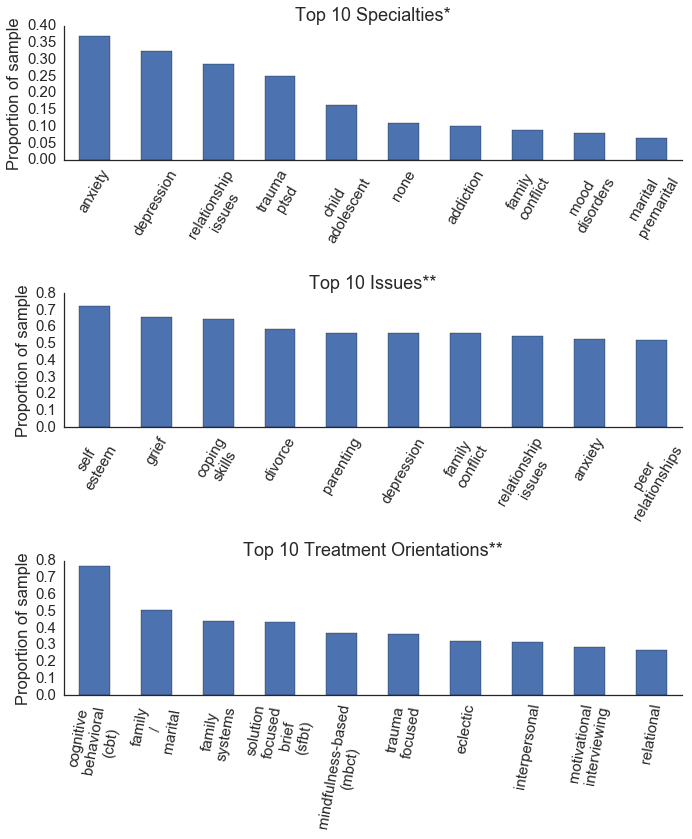

In [7]:
fig,ax = plt.subplots(3,1,figsize = (10,12))

variables = [('specialties','Specialties*', ax[0], 60),
            ('issues', 'Issues**', ax[1], 60),
            ('treatmentorientation', 'Treatment Orientations**', ax[2], 80)]
for tup in variables:
    plot_top10(*tup)

sns.despine()
fig.tight_layout();

*Specialties*: Providers can list up to 3 specialties, though a surprising number choose to list none at all. Anxiety, depression, and relationship issues are the most common specialties. This is not surprising on its own, as anxiety and depression are the most common mental disorders, and relationship issues are an exceedingly common reason to seek therapy. Echoing trends in people's degrees, relatively few providers are considered addiction specialists, but a higher proportion of the sample list this as a specialty than hold a addiction-specific title. However, this may be proportional to the need. SAMSHA cites a [prevalence of 8%](https://www.samhsa.gov/disorders) in 2014.
 
*Issues*: Providers' choices of specialties are a bit more interesting in light of their choices of issues. Providers can list as many issues as they'd like (some profiles have 60-70 issues listed!). A common theme among the top issues handled by providers is relationships: relationships with the self (self-esteem), with the deceased or lost (grief), or with [ex-]spouses and children. This is an interesting twist to think about -- considering the predominant focus of American culture is on personal achievement and independence, much of therapy is about dealing with problems of interdependence.

*Treatment orientations*: CBT reigns supreme - 70-80% of providers say they provide CBT. And rightfully so. No other treatment orientation has as much empirical support for its effectiveness across a wide variety of disorders and problems. However, the incredibly high number of providers indicating CBT as a treatment orientation should also give us pause. CBT is more than a treatment orientation; it is a very specific, highly structured, and [fully-manualized](http://hss.semel.ucla.edu/cbt-treatment-manuals/) treatment. I have serious doubts that the majority of these providers are administering CBT as intended.

Echoing the prominance of relationship-themed issues, many of the top 10 treatment orientations here are designed for addressing relationship problems.

In the future, I hope to use this data to conduct a network analysis to visualize the structure of how different problems tend to be related. Stay tuned.

## Cost and Coverage

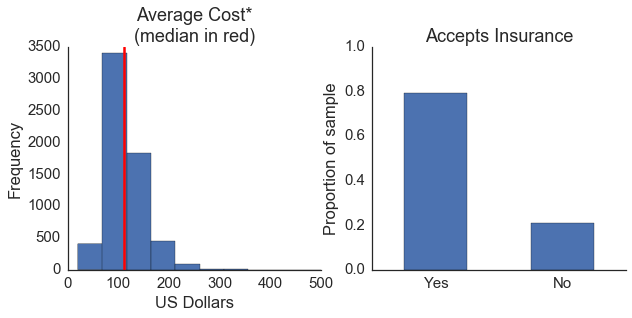

In [8]:
fig, ax = plt.subplots(1,2, figsize = (10, 4))
data.fee.hist(grid = False, ax = ax[0])
ax[0].set_title('Average Cost*\n(median in red)')
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('US Dollars')
ax[0].axvline(data.fee.median(),color = 'red')

insurance = proportions(data.insurance.fillna('No'))
insurance.plot(kind = 'bar', title = 'Accepts Insurance', ax = ax[1], ylim=(0,1), rot=0)
ax[1].set_ylabel('Proportion of sample')
sns.despine()

Providers typically provide an upper and lower bound for their fee. I've taken each provider's midpoint in this range as his/her fee. Fortunately therapy appears to be relatively affordable. The median out of pocket cost is just over $100 per hour, and about 80\% of providers accept insurance. This means most of the time, individuals may only be responsible for a copay.

In [9]:
print 'Mean fee by gender\n'.format()
print data.groupby(data.gender2).fee.mean()

Mean fee by gender

gender2
female     113.823290
male       113.365385
unknown    112.542525
Name: fee, dtype: float64


Interestingly, there doesn't seem to be a wage-gap based on gender. Male and female provideres charge the same fees.

--------------

# Conclusions

The average therapist/counselor in private practice (advertising on Psychology Today) is a master's level Counselor or Clinical Social Worker; she has up to 20 years of experience; she treats a variety of relationship and self-esteem issues, and may also deal with depression or anxiety.


### Limitations
Because PT is an opt-in advertising service, there is certainly a selection bias in any sample of profiles taken from PT. Because these professional profiles typically are for private practices (not always, however), providers who work out of hospitals or other large treatment centers/organization (e.g., the VA, Kaiser, community clinics) are less likely to have a PT profile. It is possible that these providers may have a different set of characteristics than those in private practice (perhaps shorter average duration of treatment, more likely to take insurance, more likely to have certain types of degrees and training, more likely to treat more severe forms of psychopathology). As such, PT profile data cannot be used to understand the overall mental health field in the US. It is best thought of as an overview of the private-practice field (and even this is a bit biased, since there are certain clusters of private-practictioners who are less likely to have a PT profile). It is also likely that the stats shown here reflect an, on average, younger slice of providers. Older providers with a more established practice and local reputation may be less likely to require advertisements for their services, and even then, are probably less likely to use an internet service to do so.